# Imports

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


import os
import json

from rnn_utils import DiagnosesDataset, split_dataset, MYCOLLATE
from rnn_utils import train_one_epoch, eval_model
from Logits2Predictions import Logits2Predictions

from mourga_variational.variational_rnn import VariationalRNN

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence, pack_sequence

import numpy as np
import pandas as pd

idx = pd.IndexSlice

from config import Settings; settings = Settings()

# display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Parameters

In [2]:
experiment_id = 'A'

sanity check

In [3]:
experiment_folder = os.path.join(settings.data_base,settings.variational_data_folder,experiment_id)
assert os.path.exists(experiment_folder),f'Experiment {experiment_id} data doesn\'t exist. You can create it with <CreateVariationalOutputs.ipynb>'

## Compute variances

In [4]:
var_path = os.path.join(experiment_folder,'variational_forward.csv')
det_path = os.path.join(experiment_folder,'deterministic_forward.csv')
golden_path = os.path.join(experiment_folder,'golden.csv')

df_var = pd.read_csv(var_path,index_col=[0,1,2])
df_det = pd.read_csv(det_path,index_col=[0,1])
df_golden = pd.read_csv(golden_path,index_col=[0,1])

df_var.head(2)
df_var.shape

df_det.head(2)
df_det.shape

df_golden.head(2)
df_golden.shape

diag_0    diag_1    diag_2    diag_3    diag_4  \
pat_id adm_index npass                                                     
21     1         1      0.001646  0.219600  0.087425  0.084163  0.026606   
                 2      0.001627  0.241448  0.127487  0.038899  0.002566   

                          diag_5    diag_6    diag_7    diag_8    diag_9  ...  \
pat_id adm_index npass                                                    ...   
21     1         1      0.029044  0.006477  0.005765  0.000793  0.014757  ...   
                 2      0.016236  0.004588  0.016988  0.000358  0.010856  ...   

                        diag_262  diag_263  diag_264  diag_265  diag_266  \
pat_id adm_index npass                                                     
21     1         1      0.000132  0.003995  0.000508  0.002002  0.046862   
                 2      0.000055  0.002041  0.000502  0.004578  0.077088   

                        diag_267  diag_268  diag_269  diag_270  diag_271  
pat_id adm_index npass                                                    
21     1         1      0.086731  0.001672  0.000341  0.001392  0.023608  
                 2      0.094556  0.001430  0.000183  0.001322  0.017402  

[2 rows x 272 columns]

(58290, 272)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0.005465,0.281523,0.145583,0.050645,0.005677,0.007363,0.008749,0.007137,0.000349,0.012388,...,0.000104,0.003191,0.000439,0.010623,0.082972,0.117599,0.001562,0.000729,0.002455,0.027174
23,1,0.002017,0.127589,0.118386,0.019256,0.000759,0.001934,0.023269,0.003224,0.000435,0.013632,...,0.000307,0.000991,0.000544,0.005259,0.105743,0.056455,0.001037,0.000765,0.006583,0.019564


(1943, 272)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
23,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(1943, 272)

In [5]:
df_var_predictions = df_var.groupby(['pat_id','adm_index']).mean()
df_var_predictions.head(2)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0.004267,0.222941,0.128445,0.060239,0.009996,0.012759,0.006248,0.010199,0.000776,0.014464,...,0.000093,0.002463,0.000401,0.005637,0.078653,0.112806,0.001378,0.000581,0.001420,0.021933
23,1,0.001679,0.118884,0.104866,0.019603,0.000981,0.002337,0.022711,0.004037,0.000570,0.010896,...,0.000333,0.000907,0.000396,0.003177,0.091281,0.059652,0.001135,0.000814,0.005537,0.017615


In [6]:

#common diagnoses
df_golden.sum().sort_values(ascending=False)

diag_95     758.0
diag_85     710.0
diag_93     691.0
diag_54     680.0
diag_88     663.0
            ...  
diag_163      0.0
diag_242      0.0
diag_162      0.0
diag_157      0.0
diag_155      0.0
Length: 272, dtype: float64

# Defining ideal prediction threshold for each diagnosis

For 1 diagnosis to start

In [7]:
from sklearn.metrics import roc_curve

diagnosis= 'diag_88'

testy = df_golden.loc[:,diagnosis].to_numpy().reshape((-1,1))
yhat = df_var_predictions.loc[:,diagnosis].to_numpy().reshape((-1,1))

fpr, tpr, thresholds = roc_curve(testy, yhat)

#geometric mean between sensitivity and specificity
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.315406, G-Mean=0.830


Now for all diagnoses

In [8]:
from sklearn.metrics import roc_curve
import warnings

def get_prediction_thresholds(prediction_data : pd.DataFrame, golden_data : pd.DataFrame, method='roc gm'):
    
    thresholds_data = None
    for diag in prediction_data.filter(like='diag_').columns:
        testy = golden_data.loc[:,diag].to_numpy().reshape((-1,1))
        yhat = prediction_data.loc[:,diag].to_numpy().reshape((-1,1))

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="No positive samples in y_true, true positive value should be meaningless")
            fpr, tpr, thresholds = roc_curve(testy, yhat);

        #geometric mean between sensitivity and specificity
        gmeans = np.sqrt(tpr * (1-fpr))

        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)

        threshold = pd.DataFrame(data=[[thresholds[ix],gmeans[ix]]],columns=['threshold','gmean (roc)'],index=[diag])

        if thresholds_data is None:
            thresholds_data = threshold
        else:
            thresholds_data = pd.concat([thresholds_data,threshold])
    return thresholds_data

thresholds = get_prediction_thresholds(df_var_predictions,df_golden)
thresholds

,threshold,gmean (roc)
diag_0,0.001976,0.768232
diag_1,0.188345,0.641276
diag_2,0.129781,0.586007
diag_3,0.050180,0.633603
diag_4,0.340341,0.999215
...,...,...
diag_267,0.101361,0.585618
diag_268,0.009143,0.738998
diag_269,0.001331,0.736549
diag_270,0.004743,0.603884


# Accuracy as a function of confidence

need to get predictions first

In [9]:
def predict(predictions: pd.Series, threshold : float):
    return predictions.apply(lambda x: 1 if x > threshold else 0)

predictions = df_var_predictions.apply(lambda x: predict(x,thresholds.loc[x.name,'threshold']),axis=0)

predictions.head(3)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,1,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
23,1,0,0,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,1,0
61,1,1,1,0,1,0,0,1,1,1,1,...,1,0,0,1,1,1,0,1,0,1


In [11]:
def UCE(diagnostic_preds : pd.Series,diagnostic_logits: pd.Series, diagnostic_goldens : pd.Series, nbins:int = 10):
    
    # output distribution of sigmoid
    output_probabilities = (diagnostic_logits
                     .copy()
                     .to_frame('positive_class')
                     .assign(negative_class=lambda x: 1-x.positive_class)
                    )
    # compute entropies
    entropy_calc = lambda row: -1 * sum([e * np.log2(e) for e in row])
    entropies = output_probabilities.apply(entropy_calc,axis=1)
    
    
    errors = diagnostic_preds != diagnostic_goldens
    
    uce = 0
    avg_enropy_in_bin_list = []
    errors_in_bin_list = []
    
    bins = np.linspace(0,1,num=nbins)
    idxbins = np.digitize(entropies,bins,right=True)
    for b in range(1,nbins+1):
        idx = np.where(idxbins==b)[0]
        
        if len(idx) == 0:
            # no uncertainties in this bin
            continue
            
        errors_in_bin = errors.iloc[idx].mean()
        avg_entropy_in_bin = entropies.iloc[idx].mean()
        prop_in_bin = len(idx)/len(idxbins) # Bm / n
        
        uce += np.abs(avg_entropy_in_bin - errors_in_bin) * prop_in_bin
        
        avg_enropy_in_bin_list.append(avg_entropy_in_bin)
        errors_in_bin_list.append(errors_in_bin)
        
    return uce, avg_enropy_in_bin_list, errors_in_bin_list

In [14]:
diag = 'diag_88'
diagnostic_preds = predictions.loc[:,'diag_88']
diagnostic_logits = df_var_predictions.loc[:,'diag_88']
diagnostic_goldens = df_golden.loc[:,'diag_88']
nbins = 20
uce, entropy_in_bin, errors_in_bin = UCE(diagnostic_preds,diagnostic_logits,diagnostic_goldens,nbins=nbins)

In [37]:
def plot_uncert(err, entr):
    fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.25));
    
    ax.plot([0,1], [0,1], 'k--') ;
    ax.plot(entr, err, marker='.');
    ax.set_xticks((np.arange(0, 1.1, step=0.2)));
    ax.set_ylabel(r'error');
    ax.set_xlabel(r'uncertainty');
    ax.set_xticks((np.arange(0, 1.1, step=0.2)));
    ax.set_yticks((np.arange(0, 1.1, step=0.2)));

    return fig, ax

(<Figure size 180x162 with 1 Axes>,
 <AxesSubplot:xlabel='uncertainty', ylabel='error'>)

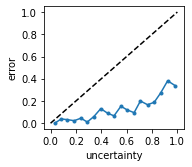

In [17]:
plot_uncert(errors_in_bin,entropy_in_bin)

## uncalibrated uncertainty for different levels of representation

In [63]:
idx = pd.IndexSlice
representation = (df_golden.sum() / df_golden.shape[0]).rename('representation')
highly_represented = representation.nlargest(3).index

In [58]:
res = []
for diag in df_golden.columns:
    diagnostic_preds = predictions.loc[:,diag]
    diagnostic_logits = df_var_predictions.loc[:,diag]
    diagnostic_goldens = df_golden.loc[:,diag]
    nbins = 20
    uce, _, _ = UCE(diagnostic_preds,diagnostic_logits,diagnostic_goldens,nbins=nbins)
    res.append((diag,uce))

In [65]:
uce_vs_repr = pd.DataFrame(res,columns=['diag','uce']).set_index('diag').join(representation)

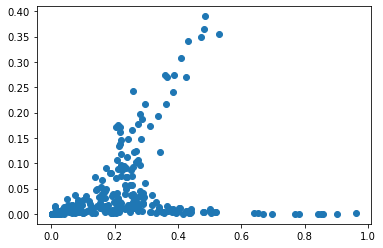

In [68]:
plt.scatter(x=uce_vs_repr['uce'],
            y=uce_vs_repr['representation'])

# Confusion matrix

## Logits to prediction through top-k selection

Choosing the top-k logits as our prediction

In [5]:
l2p = Logits2Predictions(df_det)
k = 30
top_preds = l2p.topk(k)
top_preds.head(3)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
23,1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
61,1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


## Confusion matrix for multilabel

In [11]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(df_golden,top_preds)

array([[[1932,    3],
        [   8,    0]],

       [[ 229, 1332],
        [  25,  357]],

       [[ 570, 1105],
        [  72,  196]],

       ...,

       [[1939,    2],
        [   2,    0]],

       [[1925,    0],
        [  18,    0]],

       [[1877,   19],
        [  46,    1]]])

## prediction matrix through confusion labels

In [12]:
bgolden = df_golden == True
bpred = top_preds == True

TP = (bgolden & bpred).replace({True:'TP',False:''})
TN = (~bgolden & ~bpred).replace({True:'TN',False:''})
FP = (~bgolden & bpred).replace({True:'FP',False:''})
FN = (bgolden & ~bpred).replace({True:'FN',False:''})

confusion_preds = FP + FN + TP + TN
confusion_preds

diag_0 diag_1 diag_2 diag_3 diag_4 diag_5 diag_6 diag_7  \
pat_id adm_index                                                           
21     1             TN     TP     TP     TN     TN     TN     TN     TN   
23     1             TN     FP     FP     TN     TN     TN     TN     TN   
61     1             TN     TP     FP     FN     TN     TN     TN     FN   
94     1             TN     FP     FP     TN     TN     TN     TN     TN   
105    1             TN     FP     FP     TN     TN     TN     TN     TN   
...                 ...    ...    ...    ...    ...    ...    ...    ...   
99383  3             TN     FP     FP     TN     TN     TN     TN     TN   
99650  1             TN     TN     FP     TN     TN     TN     TN     TN   
       2             TN     TN     TP     TN     TN     TN     TN     TN   
99756  1             TN     FP     FP     TN     TN     FP     TN     TN   
       2             TN     TP     FP     TN     TN     FP     TN     TN   

                 diag_8 diag_9  ... diag_262 diag_263 diag_264 diag_265  \
pat_id adm_index                ...                                       
21     1             TN     TN  ...       TN       TN       TN       TN   
23     1             TN     TN  ...       TN       TN       TN       TN   
61     1             TN     TN  ...       TN       TN       TN       TN   
94     1             TN     TN  ...       TN       TN       TN       TN   
105    1             TN     TN  ...       TN       TN       TN       TN   
...                 ...    ...  ...      ...      ...      ...      ...   
99383  3             TN     TN  ...       TN       TN       TN       TN   
99650  1             TN     TN  ...       TN       TN       TN       TN   
       2             TN     TN  ...       TN       TN       TN       TN   
99756  1             TN     TN  ...       TN       TN       TN       TN   
       2             TN     TN  ...       TN       TN       TN       TN   

                 diag_266 diag_267 diag_268 diag_269 diag_270 diag_271  
pat_id adm_index                                                        
21     1               FN       FP       TN       TN       TN       TN  
23     1               FP       TN       TN       TN       TN       TN  
61     1               FP       FP       TN       TN       TN       TN  
94     1               FP       FP       TN       TN       TN       TN  
105    1               TN       FP       TN       TN       TN       TN  
...                   ...      ...      ...      ...      ...      ...  
99383  3               TN       TN       TN       TN       TN       TN  
99650  1               FP       TN       TN       TN       TN       TN  
       2               TP       FN       TN       TN       TN       TN  
99756  1               FP       FP       TN       TN       TN       TN  
       2               TN       TN       TN       TN       TN       TN  

[1943 rows x 272 columns]

# Compute $\sigma_{pred}$  of all disease codes

In [10]:
stats = df_var.groupby(['pat_id','adm_index']).agg(['mean','std'])
stats = stats.sort_index()

stats.head(2)
stats.shape

var_stats = stats.loc[:,idx[:,'std']].droplevel(1,axis=1)
var_stats.head(2)
var_stats.shape

mean_stats = stats.loc[:,idx[:,'mean']].droplevel(1,axis=1)
mean_stats.head(2)
mean_stats.shape

diag_0              diag_1              diag_2            \
                      mean       std      mean       std      mean       std   
pat_id adm_index                                                               
21     1          0.004267  0.002544  0.222941  0.072155  0.128445  0.037834   
23     1          0.001679  0.000943  0.118884  0.043780  0.104866  0.030893   

                    diag_3              diag_4            ...  diag_267  \
                      mean       std      mean       std  ...      mean   
pat_id adm_index                                          ...             
21     1          0.060239  0.014772  0.009996  0.008262  ...  0.112806   
23     1          0.019603  0.006163  0.000981  0.000860  ...  0.059652   

                            diag_268            diag_269            diag_270  \
                       std      mean       std      mean       std      mean   
pat_id adm_index                                                               
21     1          0.036635  0.001378  0.000814  0.000581  0.000288  0.001420   
23     1          0.029006  0.001135  0.000782  0.000814  0.000358  0.005537   

                            diag_271            
                       std      mean       std  
pat_id adm_index                                
21     1          0.000554  0.021933  0.007509  
23     1          0.001843  0.017615  0.004789  

[2 rows x 544 columns]

(1943, 544)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0.002544,0.072155,0.037834,0.014772,0.008262,0.010742,0.004177,0.005410,0.000446,0.004357,...,0.000037,0.001430,0.000199,0.002648,0.036277,0.036635,0.000814,0.000288,0.000554,0.007509
23,1,0.000943,0.043780,0.030893,0.006163,0.000860,0.002635,0.011987,0.002099,0.000268,0.003597,...,0.000211,0.000351,0.000180,0.001229,0.046711,0.029006,0.000782,0.000358,0.001843,0.004789


(1943, 272)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0.004267,0.222941,0.128445,0.060239,0.009996,0.012759,0.006248,0.010199,0.000776,0.014464,...,0.000093,0.002463,0.000401,0.005637,0.078653,0.112806,0.001378,0.000581,0.001420,0.021933
23,1,0.001679,0.118884,0.104866,0.019603,0.000981,0.002337,0.022711,0.004037,0.000570,0.010896,...,0.000333,0.000907,0.000396,0.003177,0.091281,0.059652,0.001135,0.000814,0.005537,0.017615


(1943, 272)

# $\sigma_{pred}$  distribution in correct vs incorrect predictions

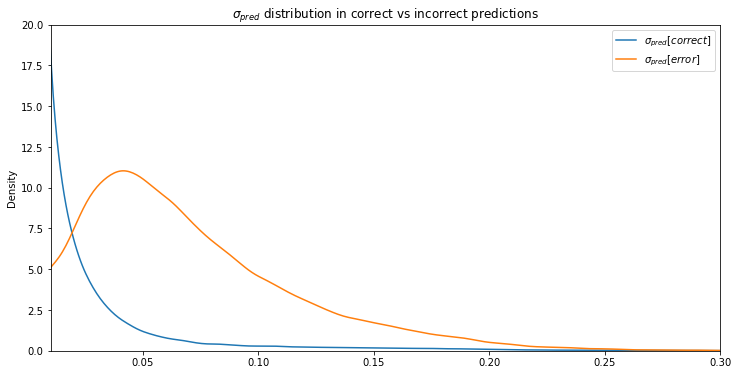

In [11]:
corrects = (confusion_preds == 'TP') | (confusion_preds == 'TN')
incorrects = ~corrects

plt.figure(figsize=(12,6));
plt.xlim(0.01,0.3);
plt.ylim(0,20);
pd.Series(var_stats.where(corrects).to_numpy().flatten()).plot.kde(label=r'$\sigma_{pred}[correct]$',bw_method=0.1);
pd.Series(var_stats.where(incorrects).to_numpy().flatten()).plot.kde(label=r'$\sigma_{pred}[error]$',bw_method=0.1);
plt.title(r'$\sigma_{pred}$ distribution in correct vs incorrect predictions');
plt.legend();
plt.show();

## Now for each label of the confusion matrix

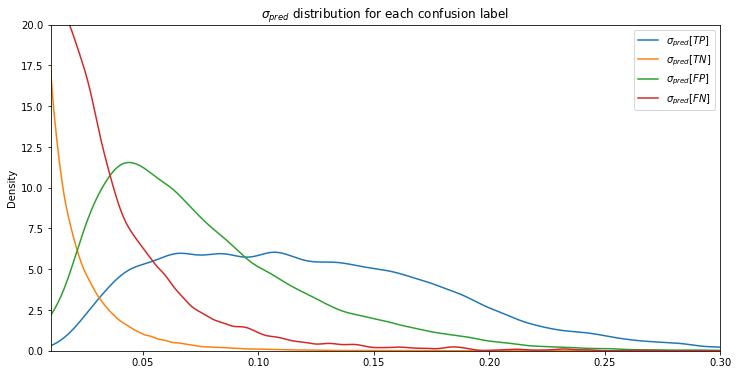

In [12]:
tp = (confusion_preds == 'TP')
tn = (confusion_preds == 'TN')
fp = (confusion_preds == 'FP')
fn = (confusion_preds == 'FN')

plt.figure(figsize=(12,6));
plt.xlim(0.01,0.3);
plt.ylim(0,20);
pd.Series(var_stats.where(tp).to_numpy().flatten()).plot.kde(label=r'$\sigma_{pred}[TP]$',bw_method=0.1);
pd.Series(var_stats.where(tn).to_numpy().flatten()).plot.kde(label=r'$\sigma_{pred}[TN]$',bw_method=0.1);
pd.Series(var_stats.where(fp).to_numpy().flatten()).plot.kde(label=r'$\sigma_{pred}[FP]$',bw_method=0.1);
pd.Series(var_stats.where(fn).to_numpy().flatten()).plot.kde(label=r'$\sigma_{pred}[FN]$',bw_method=0.1);
plt.title(r'$\sigma_{pred}$ distribution for each confusion label');
plt.legend();
plt.show();

In [14]:
(TN, FP, FN, TP) = multilabel_confusion_matrix(df_golden,top_preds).sum(axis=0).ravel()
pd.Series([TP,TN,FP,FN],index=["TP","TN","FP","FN"],name='Count').to_frame()

,Count
TP,15759
TN,463103
FP,42531
FN,7103


## What about if we include the mean?

with scipy

<AxesSubplot:>

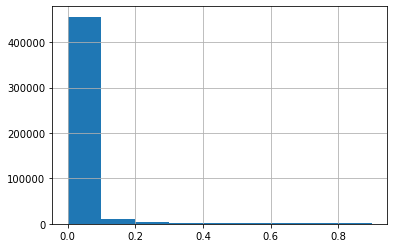

In [18]:
pd.Series(mean_values).hist(bins = [e/10 for e in range(10)])

In [23]:
import scipy
#scipy.stats.gaussian_kde

mean_values = mean_stats.where(tp).to_numpy().flatten()
var_values = var_stats.where(tp).to_numpy().flatten()

# removing nans
mean_values = mean_values[~np.isnan(mean_values)]
var_values = var_values[~np.isnan(var_values)]

x,y = mean_values,var_values

data = np.vstack([mean_values,var_values])

kernel = scipy.stats.gaussian_kde(data)

# Define the borders
xmin = 0
xmax = 1
ymin = 0
ymax = 0.3
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
positions = np.vstack([xx.ravel(), yy.ravel()])

f = np.reshape(kernel(positions).T, xx.shape)

0 1 0 0.3


Text(0.5, 0, 'mean_values')

Text(0.5, 0, 'variance')

Text(0.5, 0, 'PDF')

Text(0.5, 0.92, 'Surface plot of Gaussian 2D KDE')

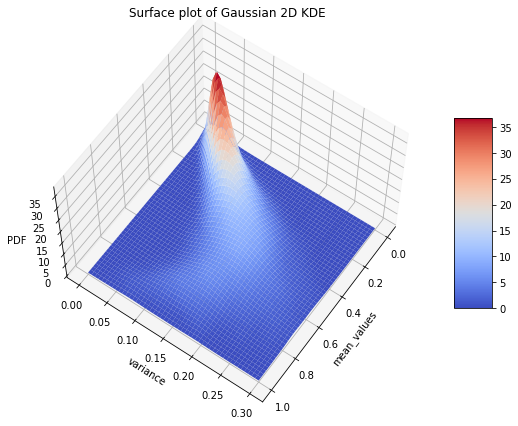

In [24]:
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('mean_values')
ax.set_ylabel('variance')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(60, 35)

In [134]:
kde_data.

array([[0.0042666 , 0.22294066, 0.1284445 , ..., 0.00933329, 0.01522352,
        0.01695126],
       [0.00254379, 0.07215535, 0.03783352, ..., 0.00544647, 0.00777209,
        0.00612653]])

with mayavi

In [ ]:
corrects = (confusion_preds == 'TP') | (confusion_preds == 'TN')
incorrects = ~corrects

plt.figure(figsize=(12,6));
plt.xlim(0.01,0.3);
plt.ylim(0,20);
pd.Series(var_stats.where(corrects).to_numpy().flatten()).plot.kde(label=r'$\sigma_{pred}[correct]$',bw_method=0.1);
pd.Series(var_stats.where(incorrects).to_numpy().flatten()).plot.kde(label=r'$\sigma_{pred}[error]$',bw_method=0.1);
plt.title(r'$\sigma_{pred}$ distribution in correct vs incorrect predictions');
plt.legend();
plt.show();

In [ ]:
import numpy as np
from scipy import stats
from mayavi import mlab

mu, sigma = 0, 0.1 
x = 10*np.random.normal(mu, sigma, 5000)
y = 10*np.random.normal(mu, sigma, 5000)
z = 10*np.random.normal(mu, sigma, 5000)

xyz = np.vstack([x,y,z])
kde = stats.gaussian_kde(xyz)
density = kde(xyz)

# Plot scatter with mayavi
figure = mlab.figure('DensityPlot')
pts = mlab.points3d(x, y, z, density, scale_mode='none', scale_factor=0.07)
mlab.axes()
mlab.show()

In [115]:
import plotly.graph_objects as go


ModuleNotFoundError: No module named 'plotly'

(0.0, 0.5)

<AxesSubplot:ylabel='Frequency'>

<AxesSubplot:ylabel='Frequency'>

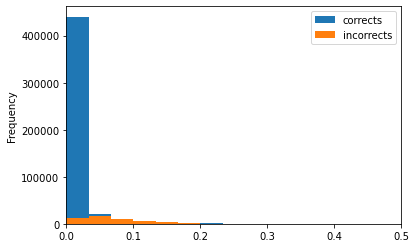

In [76]:
plt.xlim(0,0.5);
pd.Series(var_stats.where(corrects).to_numpy().flatten()).plot.hist(label='corrects',bins = [i/30 for i in range(30)])
pd.Series(var_stats.where(incorrects).to_numpy().flatten()).plot.hist(label='incorrects',bins = [i/30 for i in range(30)])
plt.legend()

## WHich diseases to look at

## Plotting distribution of $\sigma_{pred}$ for a specific disease

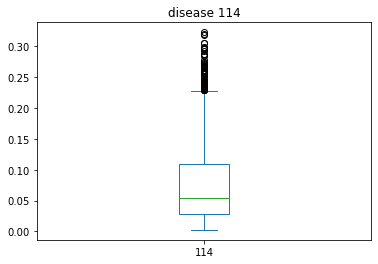

In [10]:
# choose a diagnostic

diag = '114'

std[diag].plot.box();
plt.title(f'disease {diag}');

## Now for multiple diseases

<AxesSubplot:>

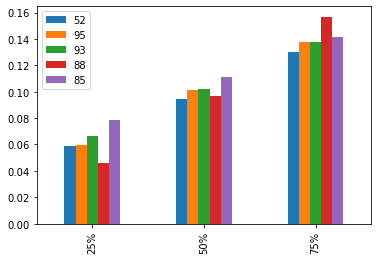

In [11]:
# choose several

topk = std.sum().sort_values().tail(5).index.tolist()
std[topk].describe().loc[['25%','50%','75%'],:].plot.bar()

Quantiles show different SD!

# Plotting uncertainty over the sigmoid output

In [12]:
diag = '114'

In [13]:
def get_values_for_diagnostic(df_det_, df_var_,diag_):
    """
    Given deterministic and variational outputs returns deterministic vector 
    of sigmoid outputs and corresponding vector of std of predictions for each of those outputs.
    """
    # produce std of outputs from variational forwards
    df_std_ = df_var_.groupby(['pat_id','adm_index']).std().sort_index()
    
    
    sigmoid_output = df_det_.set_index(['pat_id','adm_index']).sort_index()[diag_].values
    std_output = df_std_[diag_].values
    
    return sigmoid_output,std_output

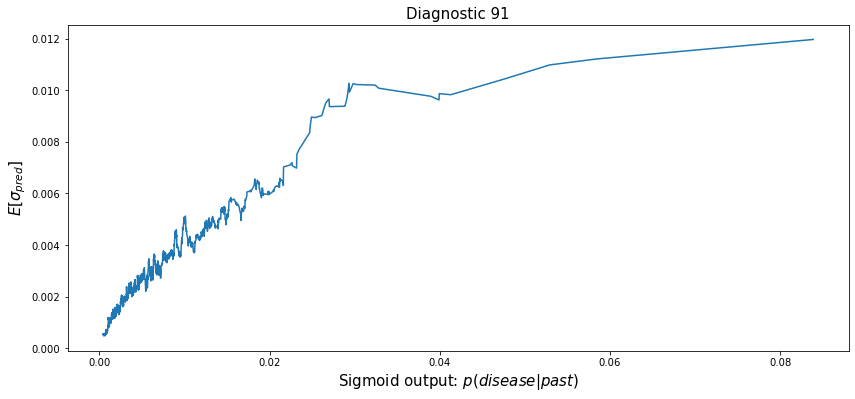

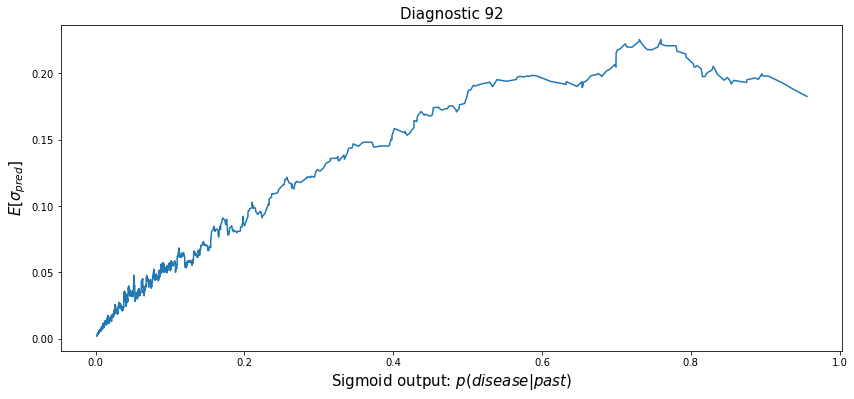

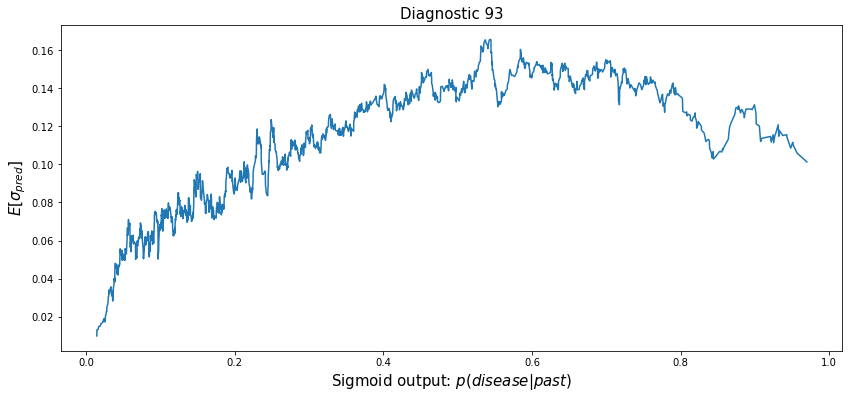

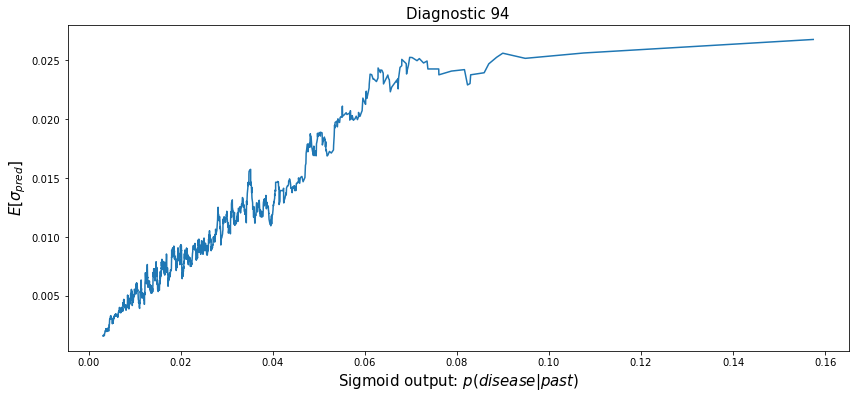

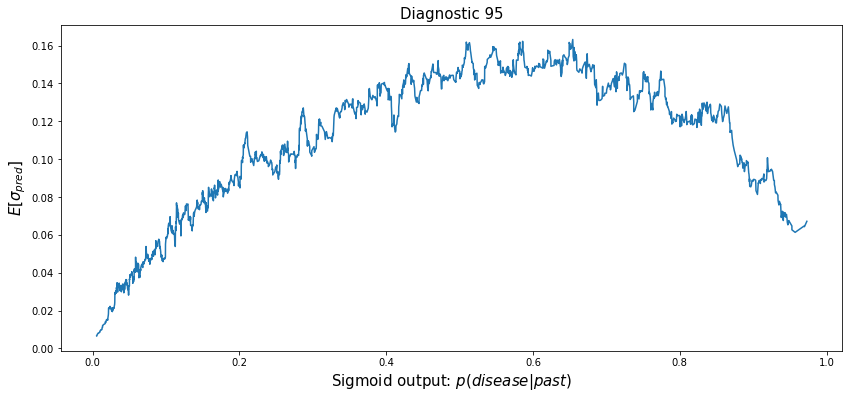

In [14]:
disease_list = [str(e) for e in range(91,96)]
for diag in disease_list:
    sigmoid,sd = get_values_for_diagnostic(df_det,df_var,diag)
    _ = plt.figure(figsize=(14,6));
    _ = pd.Series(index=sigmoid, data=sd).sort_index().rolling(window=20).mean().plot();
    _ = plt.title(f'Diagnostic {diag}',fontsize=15);
    _ = plt.xlabel('Sigmoid output: $p(disease | past)$',fontsize=15);
    _ = plt.ylabel('$E[\sigma_{pred}]$',fontsize=15);

## Now with fill_between

Now it would be nice to have the mean +- std

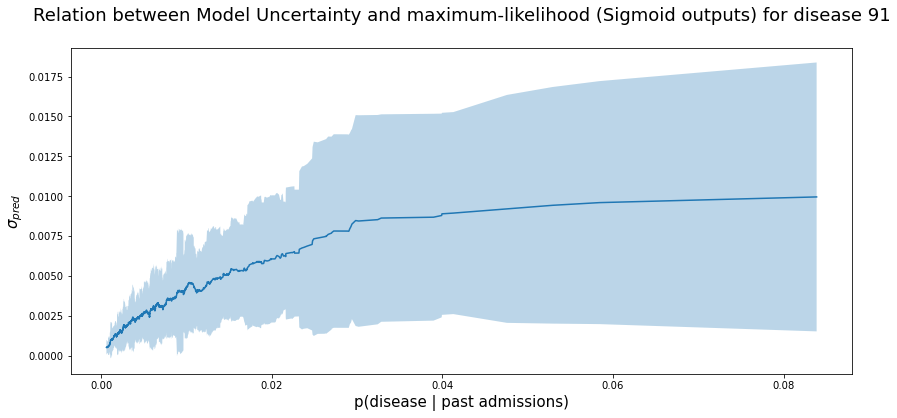

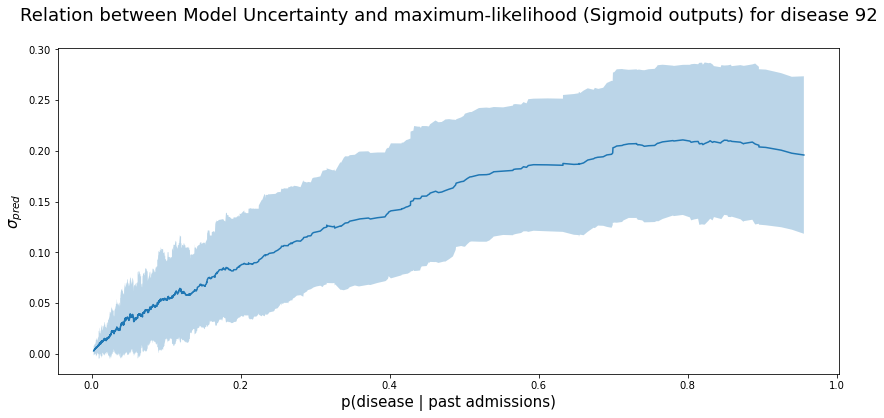

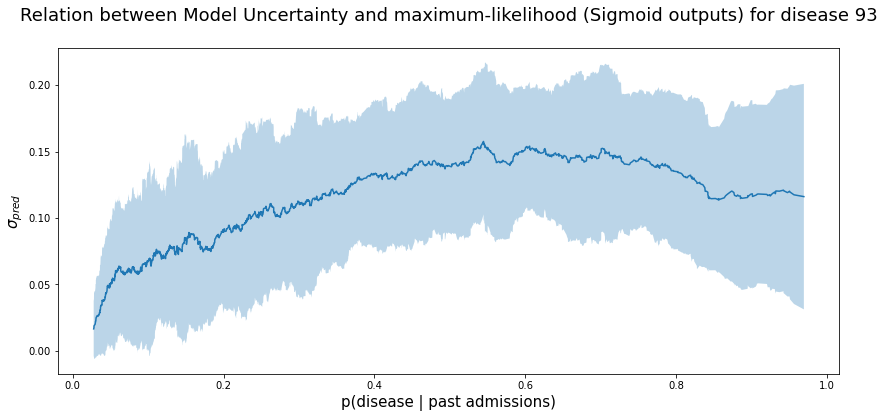

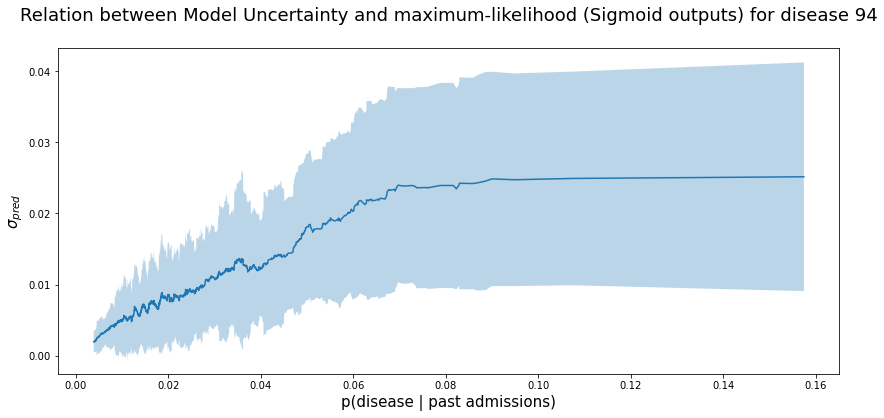

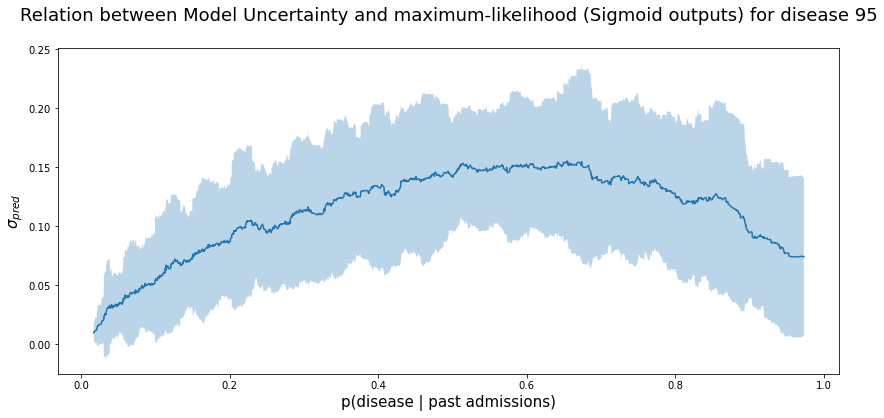

In [15]:
def plot_fill_between(x,y,diag,alpha=0.3):
    plot_data = pd.Series(index=x, data=y).sort_index().rolling(window=50).agg(['mean','std'])
    plt.figure(figsize=(14,6))
    ax = plot_data['mean'].plot()
    upper = plot_data['mean'] + 2* plot_data['std']
    lower = plot_data['mean'] - 2* plot_data['std']
    plt.fill_between(plot_data.index.to_numpy(dtype=float),lower.values,upper.values,alpha=0.3);
    plt.title(f'Relation between Model Uncertainty and maximum-likelihood (Sigmoid outputs) for disease {diag}\n',fontsize=18);
    plt.xlabel('p(disease | past admissions)',fontsize=15);
    plt.ylabel('$\sigma_{pred}$',fontsize=15);
    plt.show();

disease_list = [str(e) for e in range(91,96)]
for diag in disease_list:
    sigmoid,sd = get_values_for_diagnostic(df_det,df_var,diag)
    plot_fill_between(sigmoid,sd,diag)

## Distribution of $E_{\sigma}$ over sigmoid output

In [29]:
disease_list = [str(e) for e in range(91,96)]
for diag in disease_list:
    sigmoid,sd = get_values_for_diagnostic(df_det,df_var,diag)
    break
bins = [round(e*0.1,1) for e in range(0,11)]
bins

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

<AxesSubplot:ylabel='Frequency'>

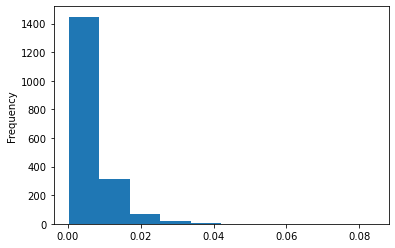

In [38]:
pd.Series(sigmoid).plot.hist()

In [34]:
np.digitize(sigmoid,bins)

1    1858
dtype: int64

# Placing a cue on prediction type: TP,FP,TN,FN

## Creating the predictions dataframe

In [16]:
def construct_prediction_df(df_det_:pd.DataFrame,diagnostic_columns,k=30):
    def out2pred(row):
        preds = row.nlargest(30).index

        return pd.Series(data=[1 if e in preds else 0 for e in row.index],
                        index=row.index)

    topk_predictions = df_det_[diagnostic_cols].apply(lambda row: out2pred(row),axis=1).assign(pat_id=df_det.pat_id,adm_index=df_det.adm_index,name=df_det['name'])
    topk_predictions.index.name = f"top {k}"
    return topk_predictions

df_topk_preds = construct_prediction_df(df_det,diagnostic_cols)
df_topk_preds.head(5)

,0,1,2,3,4,5,6,7,8,9,...,265,266,267,268,269,270,271,pat_id,adm_index,name
top 30,,,,,,,,,,,,,,,,,,,,,
0,0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,57073,1,validation_deterministic
1,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,57073,2,validation_deterministic
2,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,57073,3,validation_deterministic
3,0,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,73673,1,validation_deterministic
4,0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,22466,1,validation_deterministic


## Creating the confusion labels dataframe

In [17]:
def generate_confusion_outputs(row,df_preds):
    goldens = row.to_numpy()
    preds   = df_preds.loc[row.name].to_numpy()

    def assign_confusion_label(actual,pred):
            if actual == 1 and pred == 1:
                return 'TP'
            if actual == 1 and pred == 0:
                return 'FN'
            if actual == 0 and pred == 1:
                return 'FP'
            if actual == 0 and pred == 0:
                return 'TN'
            else:
                raise ValueError(f'Oops. Got {actual=} and {pred=}. Can only be 0 or 1.')

    data = [assign_confusion_label(**e) for e in [{'actual':gold,'pred':pred} for gold,pred in zip(goldens,preds)]]
    
    return pd.Series(data=data,
                     index=row.index
                    )
df_confusion = df_golden[diagnostic_cols].apply(lambda row: generate_confusion_outputs(row,df_topk_preds[diagnostic_cols]),axis=1).assign(pat_id=df_golden.pat_id,adm_index=df_golden.adm_index,name=df_golden['name'])
df_confusion.head(3)
df_confusion.shape

,0,1,2,3,4,5,6,7,8,9,...,265,266,267,268,269,270,271,pat_id,adm_index,name
0,TN,FP,FP,TN,TN,TN,TN,TN,TN,TN,...,TN,FP,TN,TN,TN,TN,TN,57073,1,validation_golden
1,TN,FP,FP,TN,TN,TN,TN,TN,TN,TN,...,TN,FP,FP,TN,TN,TN,TN,57073,2,validation_golden
2,TN,FP,FN,TN,TN,TN,TN,TN,TN,FN,...,FN,TP,TN,TN,TN,TN,TN,57073,3,validation_golden


(1858, 275)

## Plotting  uncertainty over sigmoid output on different confusion labels

test

In [18]:
def plot_fill_between_sidebyside(x,y,diag,mask1,mask2,alpha=0.3):
    
    x1,y1 = x[mask1],y[mask1]
    x2,y2 = x[mask2],y[mask2]
    
    
    plot_data1 = pd.Series(index=x1, data=y1).sort_index().rolling(window=10).agg(['mean','std'])
    plot_data2 = pd.Series(index=x2, data=y2).sort_index().rolling(window=10).agg(['mean','std'])
    plt.figure(figsize=(14,6))
    
    _ = plot_data1.rename(columns={'mean':'Correct'})['Correct'].plot(legend=True)
    upper = plot_data1['mean'] + plot_data1['std']
    lower = plot_data1['mean'] - plot_data1['std']
    plt.fill_between(plot_data1.index.to_numpy(dtype=float),lower.values,upper.values,alpha=0.3);
    
    _ = plot_data2.rename(columns={'mean':'Incorrect'})['Incorrect'].plot(legend = True)
    upper = plot_data2['mean'] + plot_data2['std']
    lower = plot_data2['mean'] - plot_data2['std']
    plt.fill_between(plot_data2.index.to_numpy(dtype=float),lower.values,upper.values,alpha=0.3);
    
    
    plt.title(f'Relation between Model Uncertainty and maximum-likelihood (Sigmoid outputs) for disease {diag}\n',fontsize=18);
    plt.xlabel('p(disease | past admissions)',fontsize=15);
    plt.ylabel('$\sigma_{pred}$',fontsize=15);
    plt.show()

In [19]:
mask1 = df_confusion[diag].str.match('TP')
mask2 = df_confusion[diag].str.match('FN')

sigmoid,sd = get_values_for_diagnostic(df_det,df_var,diag)


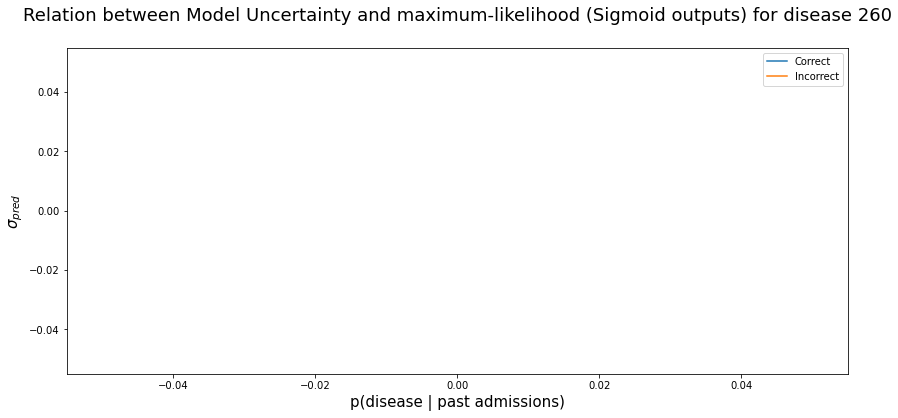

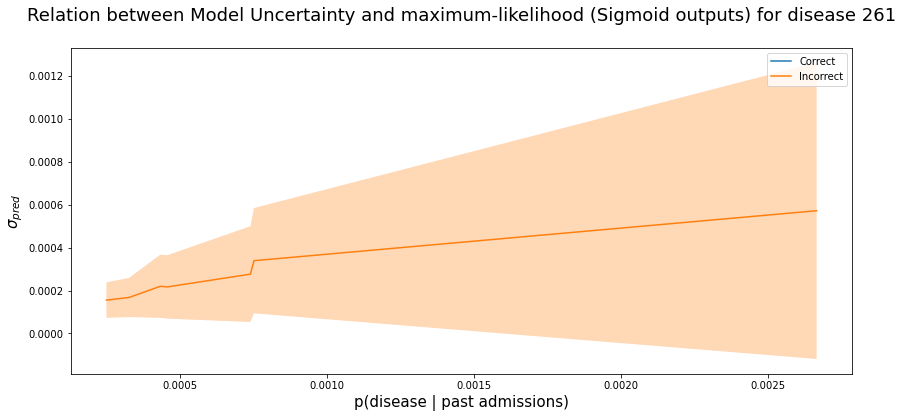

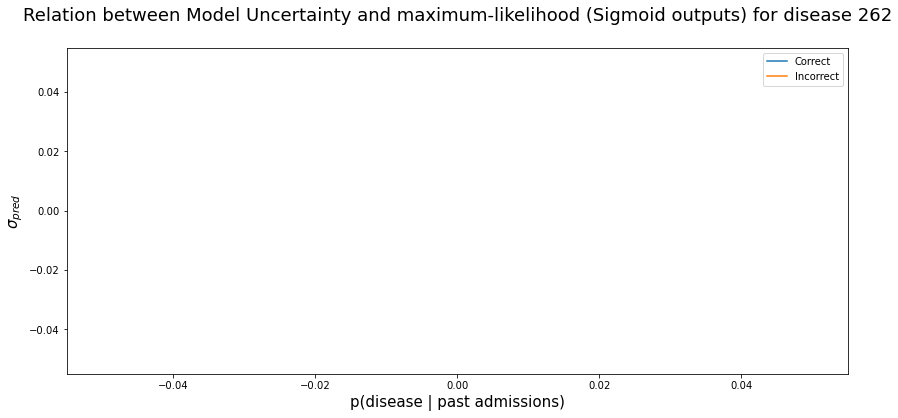

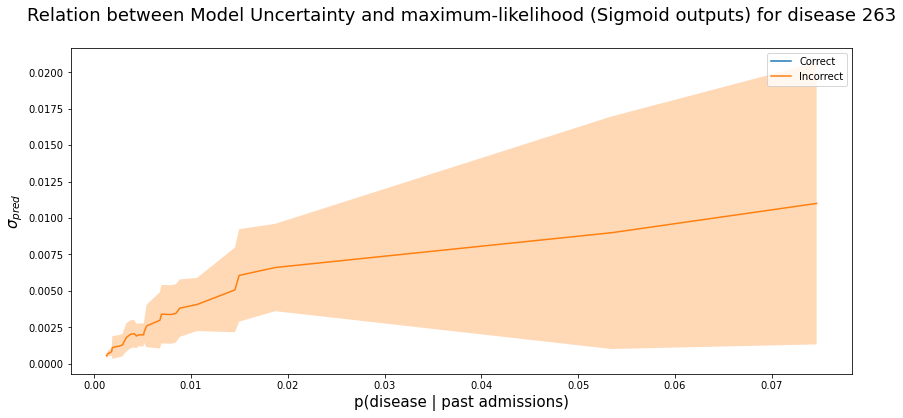

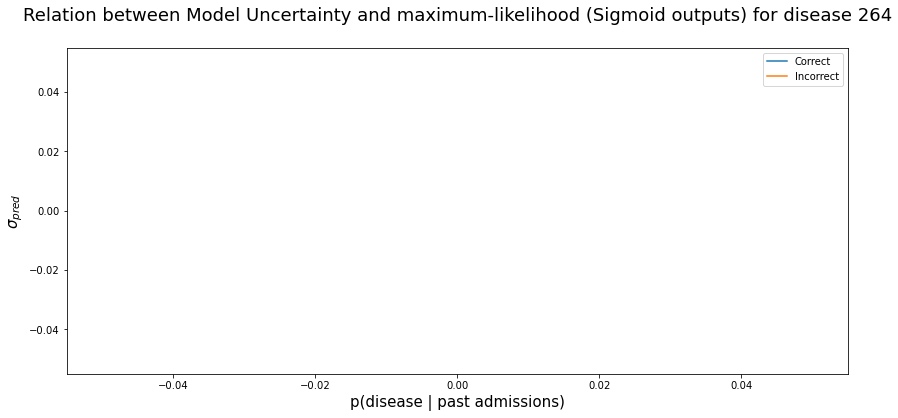

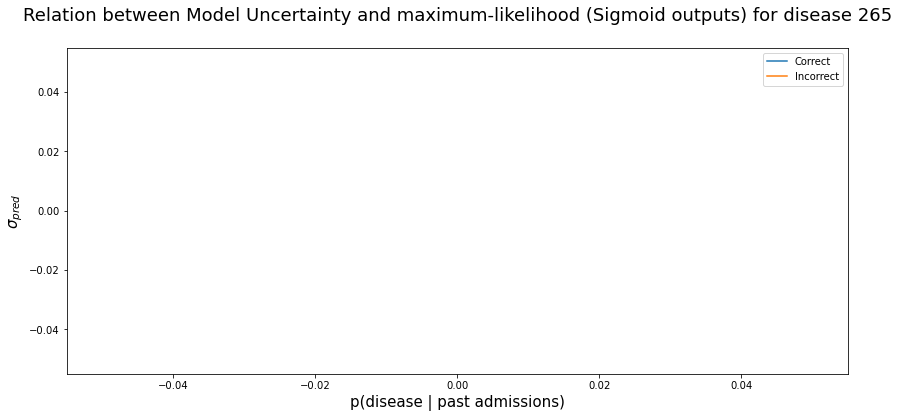

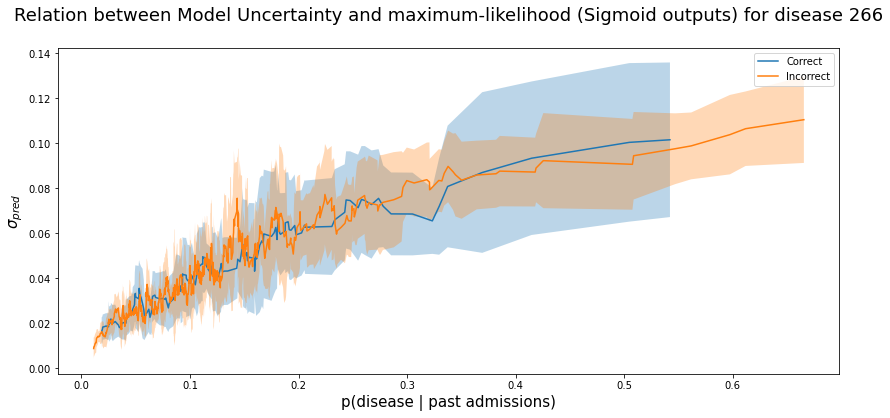

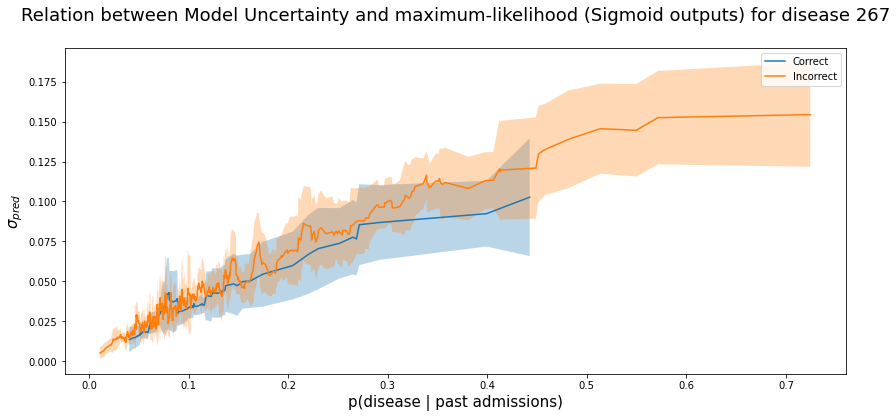

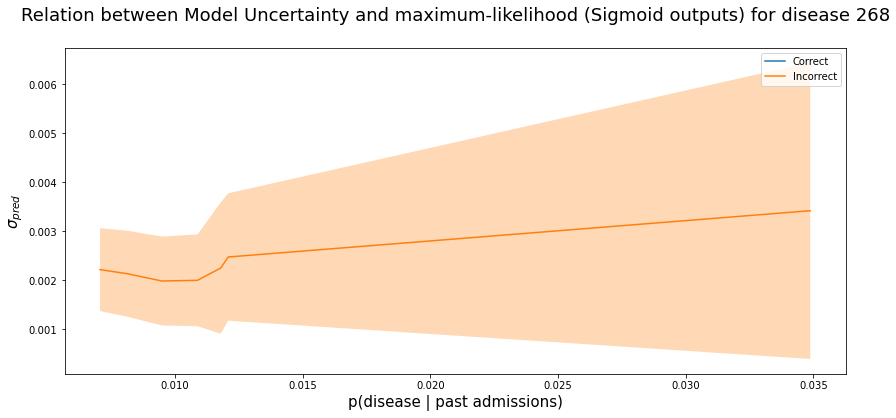

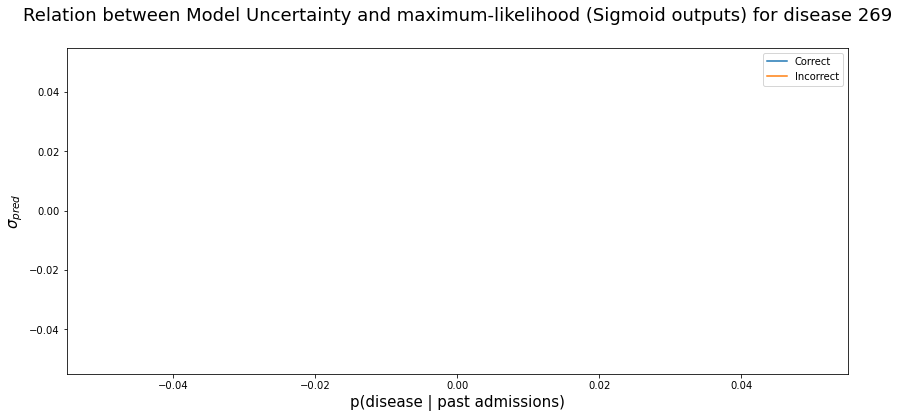

In [20]:
diag_list = [str(e) for e in range(260,270)]
for diag in diag_list:
    mask1 = df_confusion[diag].str.match('TP')
    mask2 = df_confusion[diag].str.match('FP')

    sigmoid,sd = get_values_for_diagnostic(df_det,df_var,diag)

    plot_fill_between_sidebyside(sigmoid,sd,diag,mask1,mask2)

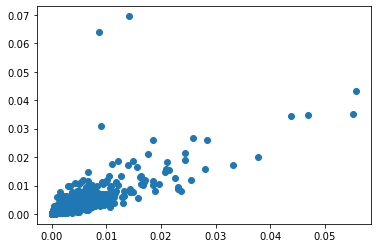

In [21]:
plt.scatter(x=sigmoid,y=sd)

In [22]:
pd.Series(x).plot.hist()
plt.show()
pd.Series(y).plot.kde()

NameError: name 'x' is not defined

Text(0.5, 1.0, 'Scatter plot')

Text(0.5, 1.0, 'Smoothing with  $\\sigma$ = 16')

Text(0.5, 1.0, 'Smoothing with  $\\sigma$ = 32')

Text(0.5, 1.0, 'Smoothing with  $\\sigma$ = 64')

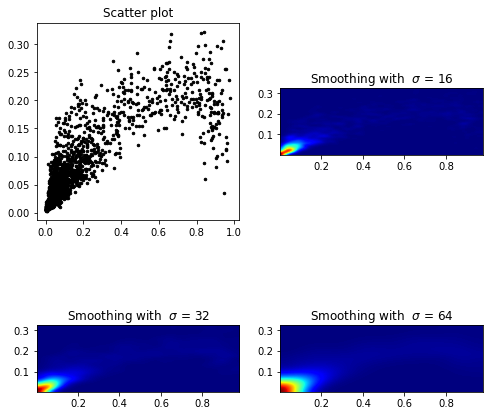

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter


def prepare_heatmap(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

fig, axs = plt.subplots(2, 2,figsize=(8,8))

# Generate some test data
x = diag_det_values
y = diag_std_values

sigmas = [0, 16, 32, 64]

for ax, s in zip(axs.flatten(), sigmas):
    if s == 0:
        ax.plot(x, y, 'k.', markersize=5);
        ax.set_title("Scatter plot");
    else:
        img, extent = prepare_heatmap(x, y, s)
        ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet);
        ax.set_title("Smoothing with  $\sigma$ = %d" % s);

#plt.show();

In [35]:
def plot_heatmap(x,y,s=15,**kwargs):
    
    if 'figsize' in kwargs:
        figsize=kwargs.get('figsize')
    else:
        figsize=(20,20)
    
    if 'diag' in kwargs:
        diag = kwargs.get('diag')
    else:
        diag = 'x'
    
    
    def prepare_heatmap(x, y, s, bins=200):
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
        heatmap = gaussian_filter(heatmap, sigma=s)

        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        return heatmap.T, extent
    
    img, extent = prepare_heatmap(x, y, s)
    plt.figure(figsize = figsize)
    plt.imshow(img, extent=extent, origin='lower', cmap=cm.jet);
    plt.title(f'Distribution of Uncertainty (std) over sigmoid output values for disease {diag}')
    plt.xlabel('Sigmoid output')
    plt.ylabel('Uncertainty (standard deviation of several passes)')
    plt.show();
    

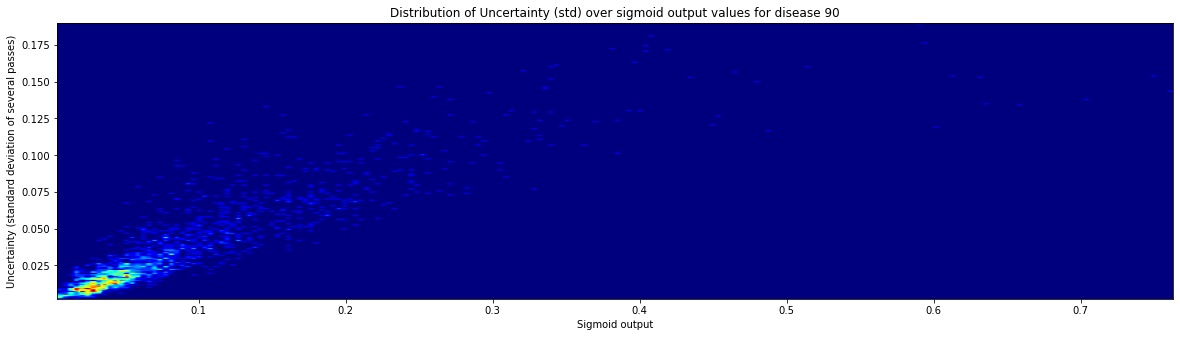

In [39]:
diag = '90'
x,y = get_values_for_diag(df_det,std,diag)
plot_heatmap(x,y,s=0,diag=diag)

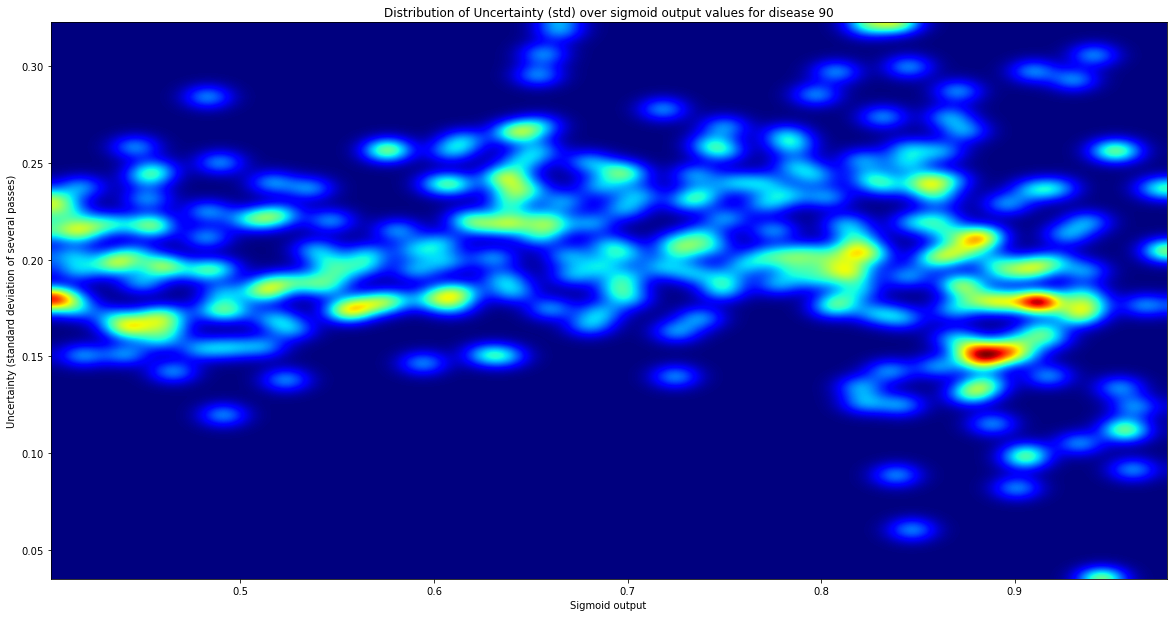

In [32]:
idx = np.where(x>0.4)[0]

#x[idx]
#y[idx]
plot_heatmap(x[idx],y[idx],diag=diag)

<Figure size 2160x720 with 0 Axes>

Text(0.5, 1.0, '')

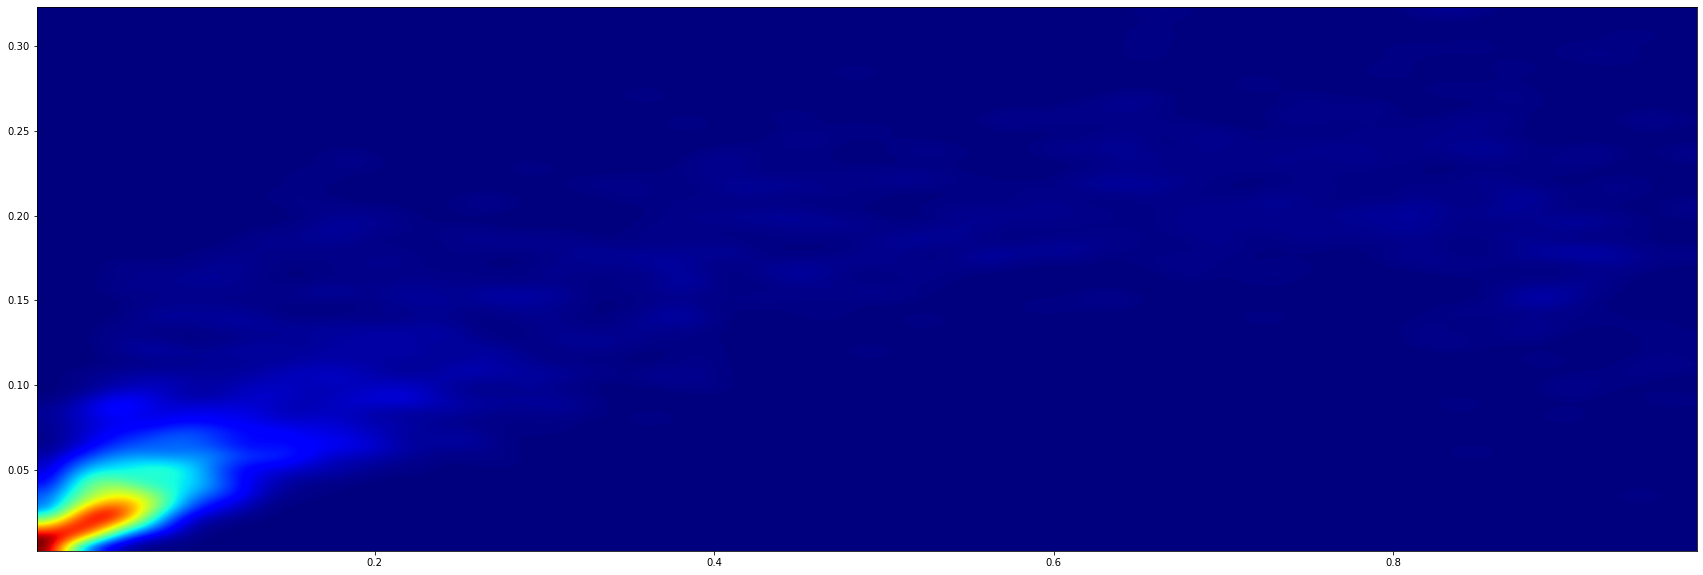

In [25]:
####
x = diag_det_values
y = diag_std_values
s = 15
img, extent = prepare_heatmap(x, y, s)
plt.figure(figsize = (30,10))
plt.imshow(img, extent=extent, origin='lower', cmap=cm.jet);
plt.title('')